# Data Pre-processing Notebook

This notebook contains the data pre-processing steps before model training. It includes:

**Data Cleaning**

- Sample Removal
- Error Margins Removal

**Encoding**

- Secondary Structure
- Reversibility

**Null Handling**

**Correlation Functions**

**Train-Test Split**

- Phase 1
- Phase 2

## Setup

1. To install the required packages, run:

```
pip install -r requirements.txt
```

2. (Optional) If you want to download the UniProt database, run:

```
python utils/download_uniprot.py
```

3. (Optional) If you want to extract protein sequences for raw_data.tsv, run:

```
python utils/seq_extract.py
```

This will create protein_seq.tsv with the extracted sequences from UniProt IDs.


In [1]:
import pandas as pd
import numpy as np
import sys
import os
import joblib
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler

sys.path.append(os.path.abspath(".."))
from utils.basic_statictical.historams import histogram
from utils.basic_statictical.seq_distribution import sequence_length_distribution
from utils.basic_statictical.correlations import (
    pearson_correlation_heatmap,
    spearman_correlation_heatmap,
)
from utils.augmentation.augment_functions import augment_sequence
from utils.embedding.embedding_functions import embed_dataset
from utils.embedding.merge_embeddings import merge_embeddings


seq_extracted = "../datasets/raw/merged_dataset.tsv"
dataset = "../datasets/protein_dataset.tsv"
Tm_dataset = "../datasets/Tm_dataset.tsv"
train_path = "../datasets/train_dataset.tsv"
val_path = "../datasets/val_dataset.tsv"
test_path = "../datasets/test_dataset.tsv"
train_augmented = "../datasets/train_dataset_augmented.tsv"
embeddings_train = "../datasets/embeddings_train.csv"
embeddings_val = "../datasets/embeddings_val.csv"
embeddings_test = "../datasets/embeddings_test.csv"
train_processed = "../datasets/train_processed.csv"
val_processed = "../datasets/val_processed.csv"
test_processed = "../datasets/test_processed.csv"

X_train_path = "../datasets/inputs/train/X_train.csv"
y_train_path = "../datasets/inputs/train/y_train.csv"
X_val_path = "../datasets/inputs/val/X_val.csv"
y_val_path = "../datasets/inputs/val/y_val.csv"
X_test_path = "../datasets/inputs/test/X_test.csv"
y_test_path = "../datasets/inputs/test/y_test.csv"
X_train_norm_path = "../datasets/inputs/train/X_train_norm.csv"
y_train_norm_path = "../datasets/inputs/train/y_train_norm.csv"
X_val_norm_path = "../datasets/inputs/val/X_val_norm.csv"
y_val_norm_path = "../datasets/inputs/val/y_val_norm.csv"
X_test_norm_path = "../datasets/inputs/test/X_test_norm.csv"
y_test_norm_path = "../datasets/inputs/test/y_test_norm.csv"

feature_scaler_path = "../models/scalers/feature_scaler.joblib"
target_scaler_path = "../models/scalers/target_scaler.joblib"

h:\study\6\ML\project\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Cleaning: Sample Removal


In [2]:
# Remove duplicates
df = pd.read_csv(seq_extracted, sep="\t", low_memory=False)

total_rows = len(df)

df_no_duplicates = df.drop_duplicates(keep="last")
rows_after_dedup = len(df_no_duplicates)
duplicates_removed = total_rows - rows_after_dedup

df_no_duplicates.to_csv(dataset, sep="\t", index=False)

print(f"Total rows before deduplication: {total_rows}")
print(f"Total rows after deduplication: {rows_after_dedup}")
print(f"Number of duplicate rows removed: {duplicates_removed}")

Total rows before deduplication: 119528
Total rows after deduplication: 79355
Number of duplicate rows removed: 40173


In [3]:
# Remove rows with no sequence
df = pd.read_csv(dataset, sep="\t", low_memory=False)
total_rows = len(df)

df_filtered = df.dropna(subset=["Protein_Sequence"])
df_filtered = df_filtered[df_filtered["Protein_Sequence"].str.strip() != "-"]

filtered_rows = len(df_filtered)
removed_rows = total_rows - filtered_rows

df_filtered.to_csv(dataset, sep="\t", index=False)

print(f"Total rows in original file: {total_rows}")
print(f"Rows removed (no sequence): {removed_rows}")
print(f"Rows remaining: {filtered_rows}")
print(f"Filtered data saved to {dataset}")

Total rows in original file: 79355
Rows removed (no sequence): 2634
Rows remaining: 76721
Filtered data saved to ../datasets/protein_dataset.tsv


Long sequences will cause runtime issues in the embedding process.
There is just one very long sequence in the dataset with 34000 amino acids, so we can remove it.


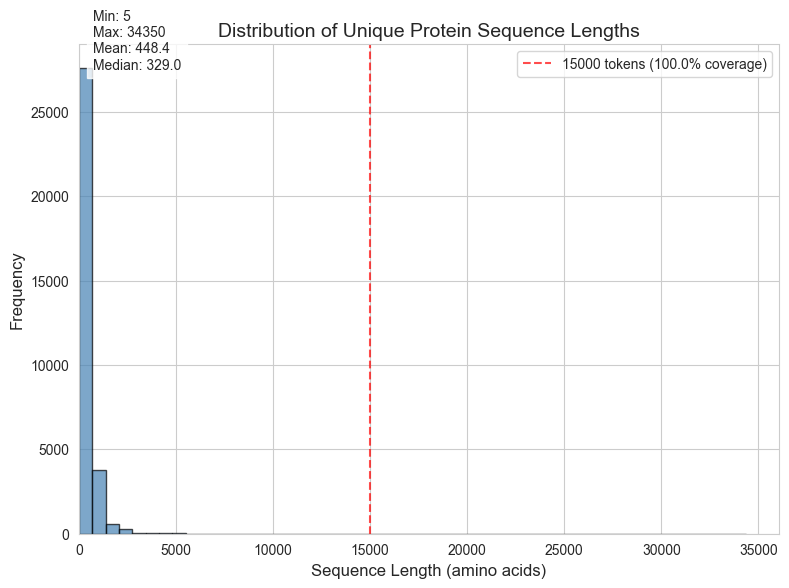

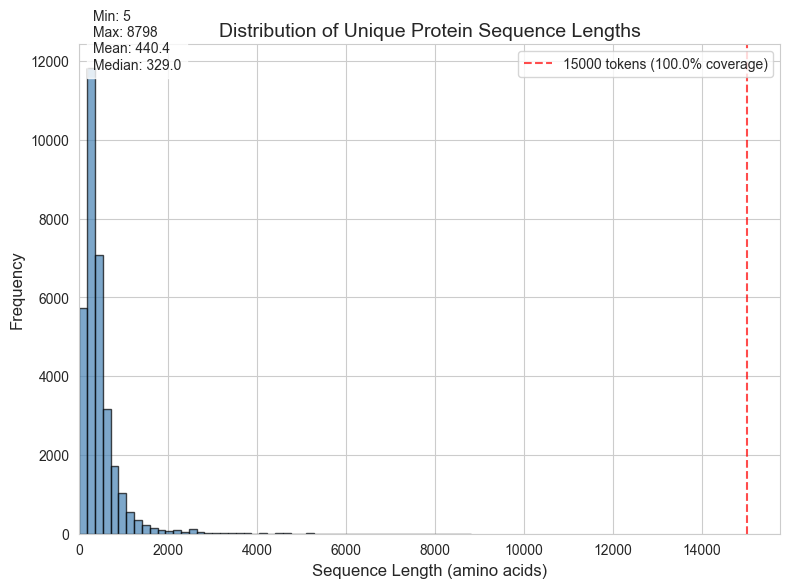

Total sequences: 76722
Sequences within length limit (15000): 76678
Sequences removed: 44 (0.06%)

Unique sequences before filtering: 32365
Unique sequences after filtering: 32357
Unique sequences removed: 8 (0.02%)


In [4]:
# Remove sequences longer than max_length
max_length = 8000
sequence_length_distribution(dataset, max_length)

df = pd.read_csv(dataset, sep="\t", header=None, low_memory=False)

sequence_col = df.iloc[:, -1]
sequence_lengths = sequence_col.str.len()
filtered_df = df[sequence_lengths <= max_length]
filtered_df.to_csv(dataset, sep="\t", header=False, index=False)

sequence_length_distribution(dataset, max_length)

total_sequences = len(df)
filtered_sequences = len(filtered_df)
removed_sequences = total_sequences - filtered_sequences

unique_sequences_before = sequence_col.nunique()
unique_sequences_after = filtered_df.iloc[:, -1].nunique()
unique_sequences_removed = unique_sequences_before - unique_sequences_after

print(f"Total sequences: {total_sequences}")
print(f"Sequences within length limit ({max_length}): {filtered_sequences}")
print(
    f"Sequences removed: {removed_sequences} ({removed_sequences/total_sequences*100:.2f}%)"
)

print(f"\nUnique sequences before filtering: {unique_sequences_before}")
print(f"Unique sequences after filtering: {unique_sequences_after}")
print(
    f"Unique sequences removed: {unique_sequences_removed} ({unique_sequences_removed/unique_sequences_before*100:.2f}%)"
)

## Data Cleaning: Error Margins Removal


Some numerical values in the dataset include error margins in parentheses.

For example: "123 (12)" indicates a value of 123 with an error of ±12.

To simplify the data, we remove the error margins and keep only the main values.


In [5]:
df = pd.read_csv(dataset, sep="\t", low_memory=False)


def clean_value(value):

    if isinstance(value, str):

        if value.strip() == "-":
            return value

        if "(" in value:

            return value.split("(")[0].strip()
    return value


df_clean = df.copy()


columns_to_clean = []
for col in df_clean.columns:

    if df_clean[col].astype(str).str.contains(r"\(.*\)").any():
        columns_to_clean.append(col)


print(f"Found {len(columns_to_clean)} columns with bracket values: {columns_to_clean}")

for col in columns_to_clean:
    if col in df_clean.columns:

        df_clean[col] = df_clean[col].apply(clean_value)

        if col not in ["STATE", "REVERSIBILITY", "SEC_STR", "UniProt_ID", "PDB_wild"]:

            df_clean[col] = df_clean[col].apply(
                lambda x: pd.to_numeric(x, errors="coerce") if x != "-" else x
            )


print("\nCleaned values:")
for col in df.columns:

    orig_values = df[col].astype(str).str.contains(r"\(\d+\.?\d*\)")

    if orig_values.any():

        idx = orig_values.idxmax()
        print(
            f"Column {col} - Original: {df[col][idx]} → Cleaned: {df_clean[col][idx]}"
        )


df_clean = df_clean.fillna("-")


df_clean.to_csv(dataset, sep="\t", index=False, na_rep="-")


print(f"\nCleaned dataset saved to {dataset}")

Found 12 columns with bracket values: ['Tm_(C)', '∆Tm_(C)', '∆H_(kcal/mol)', '∆Cp_(kcal/mol)', '∆HvH_(kcal/mol)', '∆G_(kcal/mol)', '∆∆G_(kcal/mol)', 'm_(kcal/mol/M)', 'Cm_(M)', '∆G_H2O_(kcal/mol)', '∆∆G_H2O_(kcal/mol)', 'REVERSIBILITY']

Cleaned values:
Column Tm_(C) - Original: 58.7(0.7) → Cleaned: 58.7
Column ∆Tm_(C) - Original: 61.9 (0.4) → Cleaned: 61.9
Column ∆H_(kcal/mol) - Original: 15.8 (0.29) → Cleaned: 15.8
Column ∆Cp_(kcal/mol) - Original: -1.44 (0.24) → Cleaned: -1.44
Column ∆HvH_(kcal/mol) - Original: 104 (0.49) → Cleaned: 104
Column ∆G_(kcal/mol) - Original: 9.81 (0.18) → Cleaned: 9.81
Column ∆∆G_(kcal/mol) - Original: -0.76 (0.9) → Cleaned: -0.76
Column m_(kcal/mol/M) - Original: 1.7 (0.2) → Cleaned: 1.7
Column Cm_(M) - Original: 1.86(0.01) → Cleaned: 1.86
Column ∆G_H2O_(kcal/mol) - Original: 2.95 (0.19) → Cleaned: 2.95
Column ∆∆G_H2O_(kcal/mol) - Original: 0.62 (0.06) → Cleaned: 0.62
Column REVERSIBILITY - Original: yes(0.94) → Cleaned: yes

Cleaned dataset saved to ../

## Encoding: Secondary Structure


**cleaning the SEC_STR column:**

There is one entry with SEC_STR value = -4.38, which is not a valid secondary structure.
After checking the data, it seems to be a mistake in the data collection process. The relevant entries are as follows:

| PDB_ID | UniProt_ID | PDB_wild | SEC_STR |
| ------ | ---------- | -------- | ------- |
| 27495  | P06654     | 1PGA     | Coil    |
| 27496  | P06654     | 1PGA     | Coil    |
| 27497  | P06654     | 1PGA     | -4.38   |
| 27498  | P29160     | 3N4Y     | -       |

accourding to the neighbouring entries, the correct SEC_STR value should be "Coil".


In [6]:
df = pd.read_csv(dataset, sep="\t", low_memory=False)

found = False
for idx, row in df.iterrows():
    if row["SEC_STR"] == "-4.38":
        df.at[idx, "SEC_STR"] = "Coil"
        found = True

if found:
    df.to_csv(dataset, sep="\t", index=False)
    print("File saved with the corrected SEC_STR value.")
else:
    print("No entry found with SEC_STR value = -4.38")

File saved with the corrected SEC_STR value.


**Count-Based Encoding of Secondary Structure:**

There are 4 secondary structure types: `Coil, Helix, Sheet, Turn`

Each sample has a number of each secondary structure type, we can count the number of types and represent it as a vector.

**Encoded vector:** `[Coil-count, Helix-count, Sheet-count, Turn-count]`


In [7]:
COIL = 0
HELIX = 1
SHEET = 2
TURN = 3


def encode_secondary_structure(structure_text):
    if not structure_text or structure_text == "-":
        return [0, 0, 0, 0]

    counts = [0, 0, 0, 0]
    structures = [s.strip() for s in structure_text.split(",")]

    for structure in structures:
        if "Coil" in structure:
            counts[COIL] += 1
        elif "Helix" in structure:
            counts[HELIX] += 1
        elif "Sheet" in structure:
            counts[SHEET] += 1
        elif "Turn" in structure:
            counts[TURN] += 1

    return counts


df = pd.read_csv(dataset, sep="\t", low_memory=False)
df["SEC_STR_ENCODED"] = df["SEC_STR"].apply(encode_secondary_structure)
df.to_csv(dataset, sep="\t", index=False)

print("\nSecondary Structure Types and Their Encodings:")
print("-" * 50)
print(f"{'Secondary Structure':<25} {'Count-Based Encoding'}")
print("-" * 50)

examples = [
    "Coil",
    "Helix",
    "Sheet",
    "Turn",
    "Helix, Sheet",
    "Helix, Turn, Turn",
    "-",
]

for example in examples:
    encoding = encode_secondary_structure(example)
    print(f"{example:<25} {encoding}")


Secondary Structure Types and Their Encodings:
--------------------------------------------------
Secondary Structure       Count-Based Encoding
--------------------------------------------------
Coil                      [1, 0, 0, 0]
Helix                     [0, 1, 0, 0]
Sheet                     [0, 0, 1, 0]
Turn                      [0, 0, 0, 1]
Helix, Sheet              [0, 1, 1, 0]
Helix, Turn, Turn         [0, 1, 0, 2]
-                         [0, 0, 0, 0]


## Encoding: Reversibility


The reversibility values are mostly `yes` or `no` booleans so we mapped them to numerical values between -1 and 1:

- "yes" -> 1.0 (fully reversible)
- "no" -> 0.0 (not reversible)
- "unknown"/"unknownnouwn" -> -1.0 (unknown status)
- "partially reversible" -> 0.5 (half reversible)
- "yes, 90%" -> 0.9 (90% reversible)
- "70% reversible" -> 0.7 (70% reversible)
- "> 90%" -> 0.95 (more than 90% reversible)


In [8]:
df = pd.read_csv(dataset, sep="\t", low_memory=False)


def map_reversibility(value):
    if isinstance(value, str):
        if value.lower() == "yes":
            return 1.0
        elif value.lower() == "no":
            return 0.0
        elif value.lower() in ["unknown", "unknownnouwn"]:
            return -1.0
        elif value.lower() == "partially reversible":
            return 0.5
        elif value.lower() == "yes, 90%":
            return 0.9
        elif value.lower() == "70% reversible":
            return 0.7
        elif value.lower() == "> 90%":
            return 0.95
    return value


df["REVERSIBILITY"] = df["REVERSIBILITY"].apply(map_reversibility)

df.to_csv(dataset, sep="\t", index=False)
print("File saved with the updated REVERSIBILITY values.")

File saved with the updated REVERSIBILITY values.


## Null Removal


In [11]:
# Show the null values count and percentage in the dataset
df = pd.read_csv(dataset, sep="\t", low_memory=False, na_values=["-"])

total_rows = len(df)

null_counts = df.isna().sum()
non_null_counts = df.notna().sum()

null_percentages = (null_counts / total_rows * 100).round(2)
non_null_percentages = (non_null_counts / total_rows * 100).round(2)

results = pd.DataFrame(
    {
        "Null Count": null_counts,
        "Null %": null_percentages,
        "Non-Null Count": non_null_counts,
        "Non-Null %": non_null_percentages,
    },
    index=df.columns,
)
print(results)

                    Null Count  Null %  Non-Null Count  Non-Null %
UniProt_ID               33927   44.25           42750       55.75
PDB_wild                 49937   65.13           26740       34.87
SEC_STR                  46866   61.12           29811       38.88
ASA                          0    0.00           76677      100.00
pH                        2466    3.22           74211       96.78
T_(C)                    62634   81.69           14043       18.31
Tm_(C)                   22013   28.71           54664       71.29
∆Tm_(C)                  66604   86.86           10073       13.14
∆H_(kcal/mol)            71728   93.55            4949        6.45
∆Cp_(kcal/mol)           73612   96.00            3065        4.00
∆HvH_(kcal/mol)          71585   93.36            5092        6.64
∆G_(kcal/mol)            75295   98.20            1382        1.80
∆∆G_(kcal/mol)           63024   82.19           13653       17.81
m_(kcal/mol/M)           69524   90.67            7153        

Some features have a lot of null values, in the following we just use features with less than 75% null values including:

- ASA
- pH
- T\_(C)
- Tm\_(C)
- m\_(kcal/mol/M)
- Cm\_(M)
- ∆G*H2O*(kcal/mol)
- REVERSIBILITY
- SEC_STR_ENCODED
- Protein_Sequence

**Null Handlig Strategies:**

- `pH & T:` These are experimental conditions and most experiments were conducted under neutral conditions and room temperature (pH = 7, T = 25°C), so Null values are set as the `mode`.

- `REVERSIBILITY:` The value -1 in the REVERSIBILITY field already denotes "unknown", so the `flag -1 `is used for nulls.

- `ASA:` The null features of ASA is also assigned a `flag -1`.

Note that for `other thermodynamic features` the `Phase-1 models` will predict null values.

Histograms of features are shown before and after null handling:


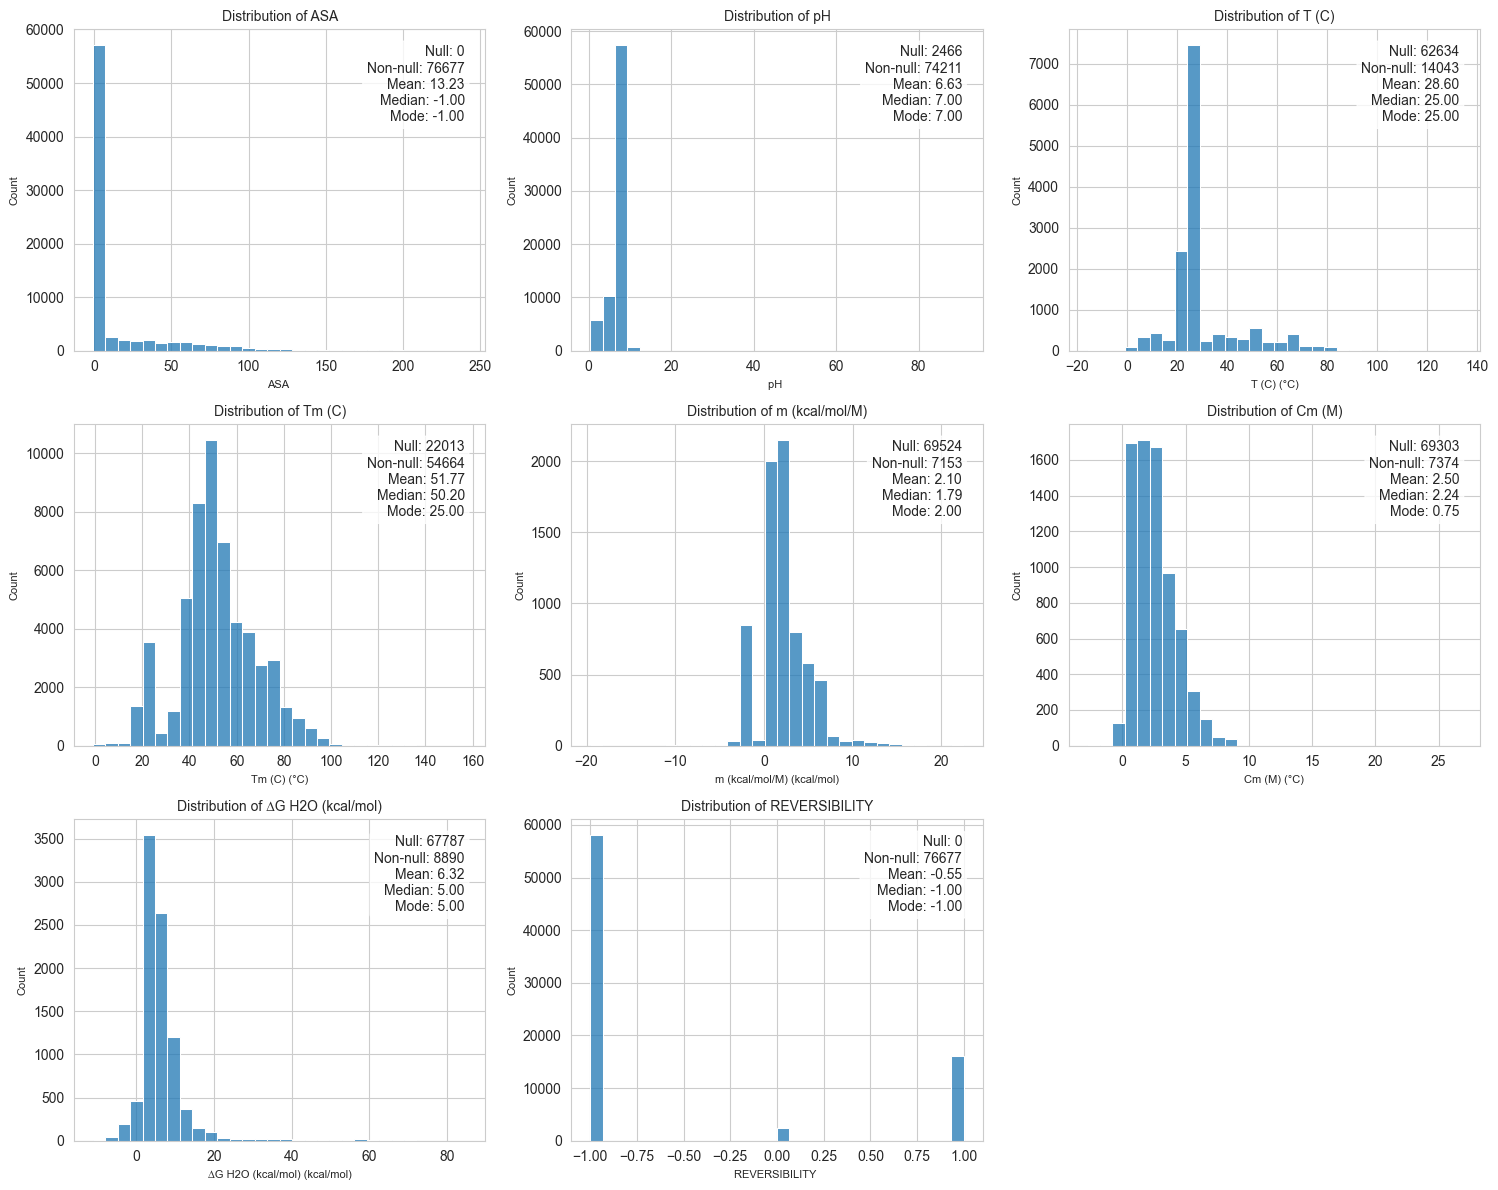

In [12]:
histogram(dataset)

df = pd.read_csv(dataset, sep="\t", low_memory=False)

df.replace("-", np.nan, inplace=True)

df["ASA"] = df["ASA"].fillna(-1)  # Flag
df["REVERSIBILITY"] = df["REVERSIBILITY"].fillna(-1)  # Flag

df["ASA"] = df["ASA"].astype(float)
df["REVERSIBILITY"] = df["REVERSIBILITY"].astype(float)

df.to_csv(dataset, sep="\t", index=False)

In [17]:
# Remove samples with null Tm value
df = pd.read_csv(dataset, sep="\t", low_memory=False)
print(f"Original dataset size: {len(df)}")

df = df.dropna(subset=["Tm_(C)"])
df.to_csv(Tm_dataset, sep="\t", index=False)
print(f"Dataset size after removing null Tm values: {len(df)}")

Original dataset size: 76677
Dataset size after removing null Tm values: 54664


## Split: Train-Test


**Data Split**

- Training set: 68%
- Val set: 17%
- Test set: 15%


In [46]:
df = pd.read_csv(Tm_dataset, sep="\t", low_memory=False)

# Extract Kaggle test sequences
kaggle_sequence = "VPVNPEPDATSVENVAEKTGSGDSQSDPIKADLEVKGQSALPFDVDCWAILCKGAPNVLQRVNEKTKNSNRDRSGANKGPFKDPQKWGIKALPPKNPSWSAQDFKSPEEYAFASSLQGGTNAILAPVNLASQNSQGGVLNGFYSANKVAQFDPSKPQQTKGTWFQITKFTGAAGPYCKALGSNDKSVCDKNKNIAGDWGFDPAKWAYQYDEKNNKFNYVGK"
kaggle_index = df[df["Protein_Sequence"] == kaggle_sequence].index[0]
kaggle_test_df = df.iloc[kaggle_index:]

reduced_df = df.iloc[:kaggle_index]
kaggle_unique_sequences = kaggle_test_df["Protein_Sequence"].nunique()
total_unique_sequences = df["Protein_Sequence"].nunique()
kaggle_percentage = (kaggle_unique_sequences / total_unique_sequences) * 100
print(
    f"Kaggle test unique sequences: {kaggle_unique_sequences} ({kaggle_percentage:.1f}%)"
)

# Target test size: 30% of unique sequences
target_test_size = int(
    (0.2 - kaggle_percentage / 100) * len(reduced_df["Protein_Sequence"].unique())
)

# Group by protein sequence and filter out groups with missing values
valid_groups = reduced_df.groupby("Protein_Sequence").filter(
    lambda x: not x["Tm_(C)"].isna().any() and not x["pH"].isna().any()
)

unique_sequences = valid_groups["Protein_Sequence"].unique()
np.random.seed(0)
selected_sequences = np.random.choice(
    unique_sequences, size=target_test_size, replace=False
)

# Create Train dataset without selected groups to prevent data leakage
test_df = valid_groups[valid_groups["Protein_Sequence"].isin(selected_sequences)]
train_df = reduced_df[~reduced_df["Protein_Sequence"].isin(selected_sequences)]
test_df = pd.concat([test_df, kaggle_test_df], ignore_index=True)

train_df.to_csv(train_path, sep="\t", index=False)
test_df.to_csv(test_path, sep="\t", index=False)

print(f"Total samples: {len(df)}")
print(f"Train samples: {len(train_df)} ({len(train_df)/len(df)*100:.1f}%)")
print(f"Test samples: {len(test_df)} ({len(test_df)/len(df)*100:.1f}%)")

print(
    f"Unique sequences in train set: {train_df['Protein_Sequence'].nunique()} ({train_df['Protein_Sequence'].nunique()/df['Protein_Sequence'].nunique()*100:.1f}%)"
)
print(
    f"Unique sequences in test set: {test_df['Protein_Sequence'].nunique()} ({test_df['Protein_Sequence'].nunique()/df['Protein_Sequence'].nunique()*100:.1f}%)"
)

Kaggle test unique sequences: 2413 (7.5%)
Total samples: 54664
Train samples: 46507 (85.1%)
Test samples: 8157 (14.9%)
Unique sequences in train set: 26043 (80.9%)
Unique sequences in test set: 6133 (19.1%)


## Null Handling


Histograms of train dataset after null handling


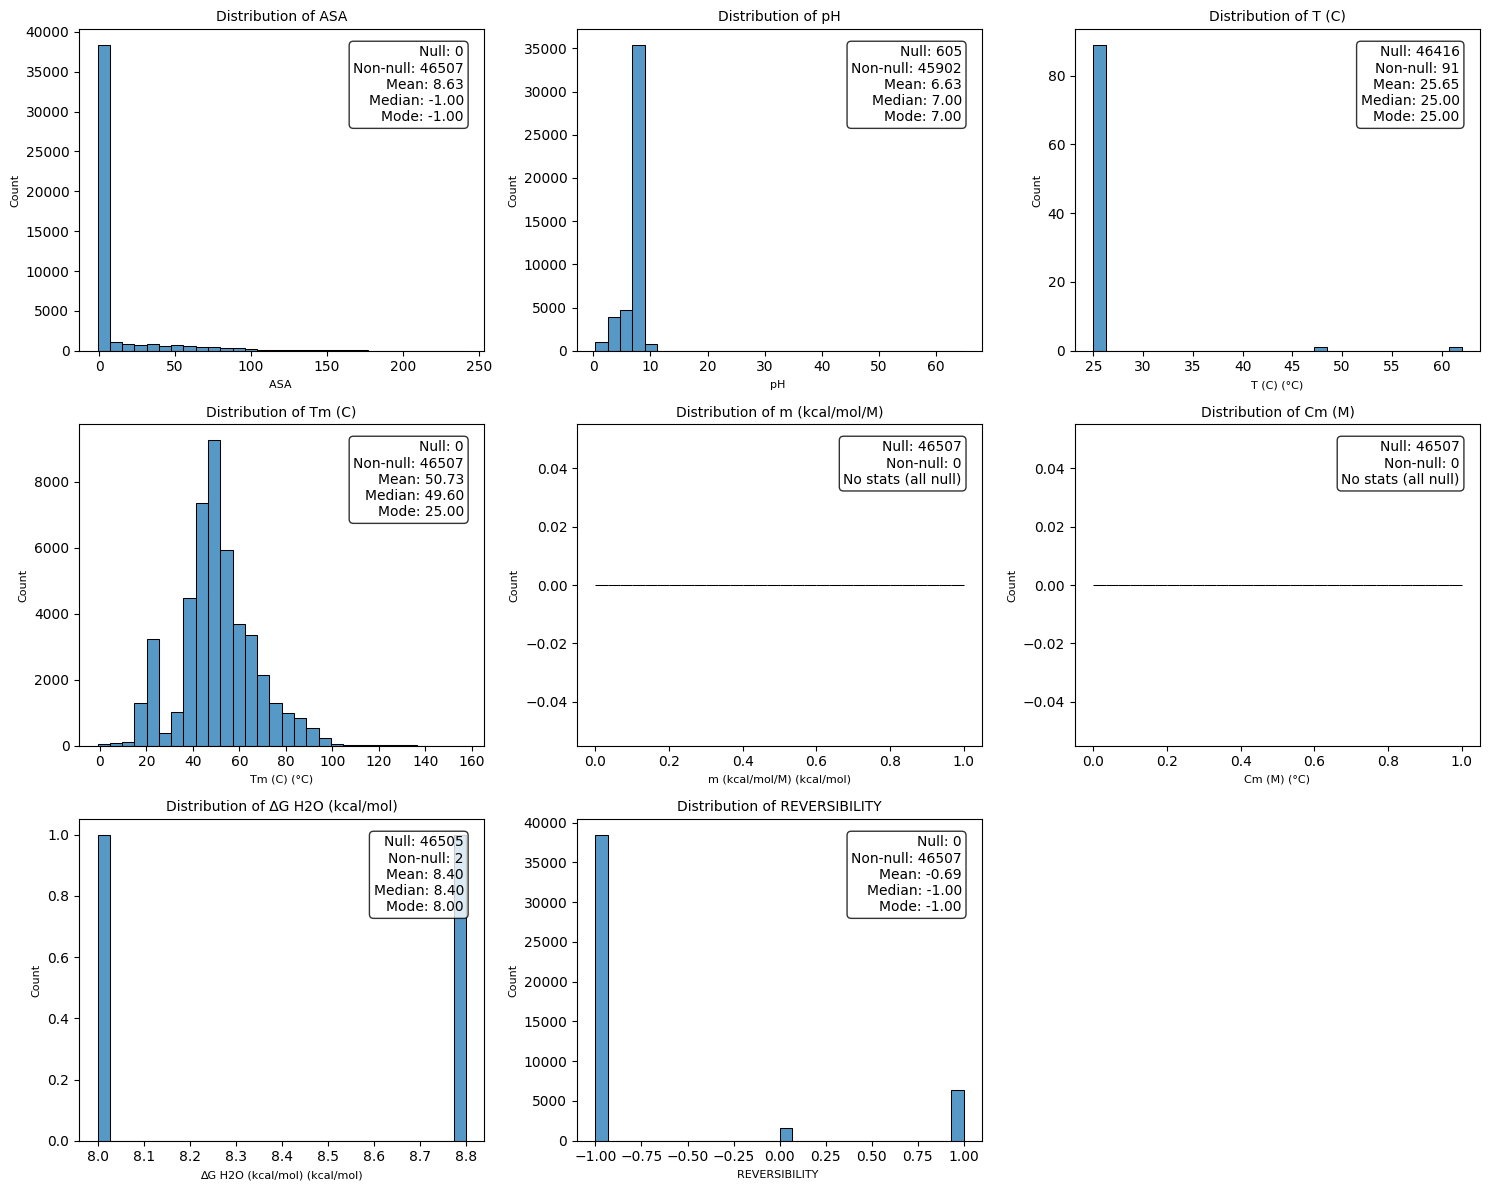

In [47]:
train_df = pd.read_csv(train_path, sep="\t", low_memory=False)

train_df["pH"] = train_df["pH"].fillna(7.0)  # Mode
train_df["pH"] = train_df["pH"].astype(float)

print("Histograms of train dataset after null handling")
histogram(train_path)

## Split: Train-Val


In [48]:
df = pd.read_csv(train_path, sep="\t", low_memory=False)

# Target val size: same as test size
target_val_size = 4900

unique_sequences = df["Protein_Sequence"].unique()
np.random.seed(0)
selected_sequences = np.random.choice(
    unique_sequences, size=target_val_size, replace=False
)

# Create Train dataset without selected groups to prevent data leakage
val_df = df[df["Protein_Sequence"].isin(selected_sequences)]
train_df = df[~df["Protein_Sequence"].isin(selected_sequences)]

train_df.to_csv(train_path, sep="\t", index=False)
val_df.to_csv(val_path, sep="\t", index=False)

print(f"Total samples: {len(df)}")
print(f"Train samples: {len(train_df)} ({len(train_df)/len(df)*100:.1f}%)")
print(f"Val samples: {len(val_df)} ({len(val_df)/len(df)*100:.1f}%)")

print(
    f"Unique sequences in train set: {train_df['Protein_Sequence'].nunique()} ({train_df['Protein_Sequence'].nunique()/df['Protein_Sequence'].nunique()*100:.1f}%)"
)
print(
    f"Unique sequences in val set: {val_df['Protein_Sequence'].nunique()} ({val_df['Protein_Sequence'].nunique()/df['Protein_Sequence'].nunique()*100:.1f}%)"
)

Total samples: 46507
Train samples: 37169 (79.9%)
Val samples: 9338 (20.1%)
Unique sequences in train set: 21143 (81.2%)
Unique sequences in val set: 4900 (18.8%)


## Correlation Functions


`Pearson` correlation is used to measure `linear` relationships between variables, while `Spearman` correlation is used to assess `monotonic` (rank-based) relationships.


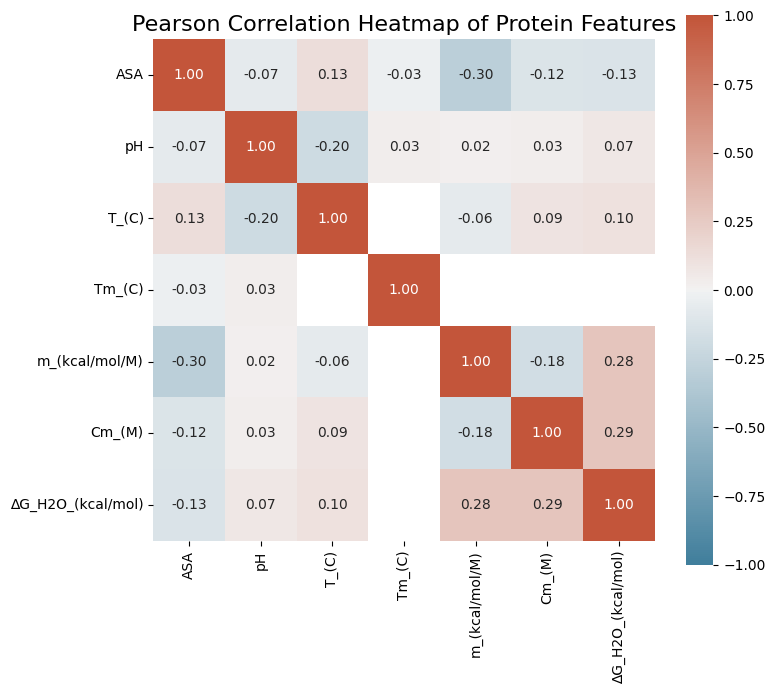

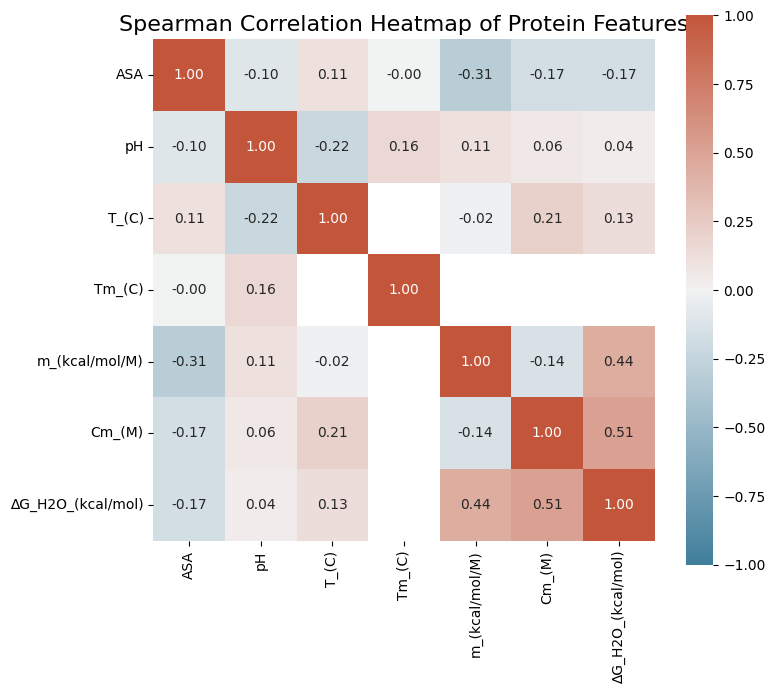

In [2]:
pearson_correlation_heatmap(dataset)
spearman_correlation_heatmap(dataset)

## Feature Removal


In [49]:
def remove_features(file_path):
    df = pd.read_csv(file_path, sep="\t", low_memory=False)

    selected_columns = [
        "ASA",
        "pH",
        "Tm_(C)",
        "SEC_STR",
        "SEC_STR_ENCODED",
        "Protein_Sequence",
    ]
    df_selected = df[selected_columns]
    df_selected.to_csv(file_path, sep="\t", index=False)


remove_features(train_path)
remove_features(val_path)
remove_features(test_path)

## Augmentation


In [50]:
min_score = 2
max_hydro_diff = 1


def augment_dataset(
    input_file, output_file, num_substitutions=[1, 2, 3], num_mutations=[15, 10, 5]
):
    """Augment protein sequences in the dataset while preserving other features."""
    df = pd.read_csv(input_file, sep="\t", low_memory=False)
    total_failed_count = 0

    augmented_data = []
    for i, (_, row) in tqdm(
        enumerate(df.iterrows()), total=len(df), desc="Augmenting sequences"
    ):
        augmented_data.append(row)
        original_seq = row["Protein_Sequence"]

        # Generate augmented sequences
        augmented_seqs, failed_count = augment_sequence(
            original_seq,
            num_substitutions=num_substitutions,
            num_mutations=num_mutations,
            min_score=min_score,
            max_hydro_diff=max_hydro_diff,
            retries=20,
            print_failures=False,
            random_seed=42,
        )
        total_failed_count += failed_count

        for aug_seq in augmented_seqs:
            new_row = row.copy()
            new_row["Protein_Sequence"] = aug_seq
            augmented_data.append(new_row)

    augmented_df = pd.DataFrame(augmented_data)

    augmented_df.to_csv(output_file, sep="\t", index=False)
    print(f"Augmented dataset saved to {output_file}")
    print(f"Original dataset size: {len(df)}")
    print(f"Augmented dataset size: {len(augmented_df)}")
    print(f"Total failed count: {total_failed_count}")


augment_dataset(
    input_file=train_path,
    output_file=train_augmented,
    num_substitutions=[1, 2, 3],
    num_mutations=[15, 10, 5],
)

Augmenting sequences: 100%|██████████| 37169/37169 [03:01<00:00, 204.27it/s]


Augmented dataset saved to ../datasets/train_dataset_augmented.tsv
Original dataset size: 37169
Augmented dataset size: 1151904
Total failed count: 335


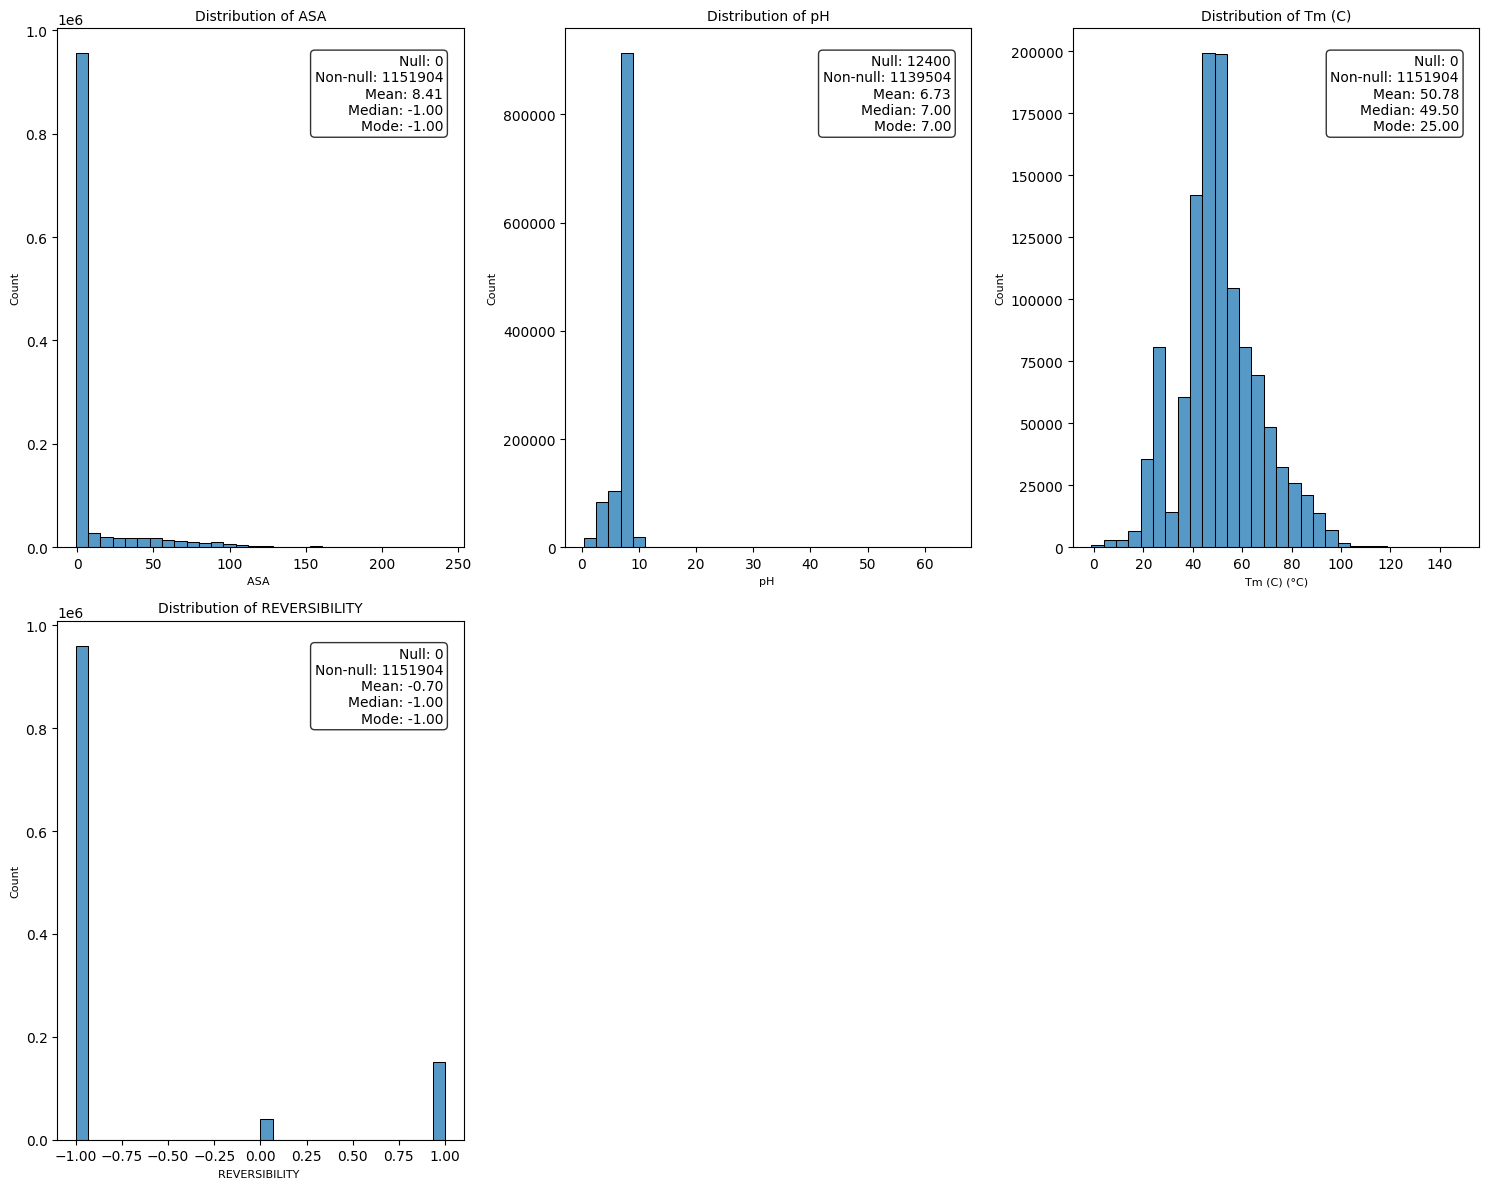

In [2]:
histogram(
    train_augmented,
    columns_to_plot=[
        "ASA",
        "pH",
        "Tm_(C)",
        "REVERSIBILITY",
    ],
)

## Dataset Embedding


Before proceeding, please refer to `notebooks/1-embedding.ipynb` to explore sequence embeddings.


In [2]:
embed_dataset(test_path, embeddings_test, batch_size=100, max_sequence_length=8000)
embed_dataset(val_path, embeddings_val, batch_size=100, max_sequence_length=8000)

Loading protein language model and tokenizer...


Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using device: cuda
Found 8866 existing sequences with embeddings
Number of new unique sequences to process: 821
Generating embeddings for new proteins...


Processing sequences: 100%|██████████| 821/821 [00:24<00:00, 33.04it/s]


Completed! Generated embeddings for 821 new proteins
Results saved to ../datasets/embeddings_test.csv
Loading protein language model and tokenizer...


Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using device: cuda
Found 0 existing sequences with embeddings
Number of new unique sequences to process: 4900
Generating embeddings for new proteins...


Processing sequences: 100%|██████████| 4900/4900 [02:56<00:00, 27.83it/s] 


Completed! Generated embeddings for 4900 new proteins
Results saved to ../datasets/embeddings_val.csv


In [2]:
merge_embeddings(
    dataset_path=test_path, embeddings_path=embeddings_test, output_path=test_processed
)
merge_embeddings(
    dataset_path=val_path, embeddings_path=embeddings_val, output_path=val_processed
)

Processing records: 100%|██████████| 9338/9338 [00:04<00:00, 2000.36it/s]


## Split: X-y


**Features**

X = [ASA, pH, Coil, Helix, Sheet, Turn, 320 × embeddings...] × 326 dimensions

**Labels**

y = Tm


In [2]:
train_data = pd.read_csv(train_processed)
val_data = pd.read_csv(val_processed)
test_data = pd.read_csv(test_processed)

len_train = len(train_data)
len_val = len(val_data)
len_test = len(test_data)

train_data = train_data.dropna()
val_data = val_data.dropna()
test_data = test_data.dropna()

print(f"Train data nulls dropped: {len_train - len(train_data)}")
print(f"Val data nulls dropped: {len_val - len(val_data)}")
print(f"Test data nulls dropped: {len_test - len(test_data)}")

X_train = train_data.drop("Tm_(C)", axis=1)
y_train = train_data["Tm_(C)"]
X_val = val_data.drop("Tm_(C)", axis=1)
y_val = val_data["Tm_(C)"]
X_test = test_data.drop("Tm_(C)", axis=1)
y_test = test_data["Tm_(C)"]

X_train.to_csv(X_train_path, index=False)
y_train.to_csv(y_train_path, index=False)
X_val.to_csv(X_val_path, index=False)
y_val.to_csv(y_val_path, index=False)
X_test.to_csv(X_test_path, index=False)
y_test.to_csv(y_test_path, index=False)

Train data nulls dropped: 12400
Val data nulls dropped: 205
Test data nulls dropped: 0


## Normalization


In [ ]:
# TODO: Seperate ASA and other columns scalers

X_train_norm = X_train.copy()
X_val_norm = X_val.copy()
X_test_norm = X_test.copy()

asa_col = "ASA"
cols_to_normalize = [
    col for col in X_train.columns if col not in ["Coil", "Helix", "Sheet", "Turn"]
]

train_asa_mask = X_train[asa_col] != -1
val_asa_mask = X_val[asa_col] != -1
test_asa_mask = X_test[asa_col] != -1

scaler = MinMaxScaler()

# Scale ASA values that are not -1
X_train_norm.loc[train_asa_mask, asa_col] = scaler.fit_transform(
    X_train.loc[train_asa_mask, asa_col].values.reshape(-1, 1)
)
X_val_norm.loc[val_asa_mask, asa_col] = scaler.transform(
    X_val.loc[val_asa_mask, asa_col].values.reshape(-1, 1)
)
X_test_norm.loc[test_asa_mask, asa_col] = scaler.transform(
    X_test.loc[test_asa_mask, asa_col].values.reshape(-1, 1)
)

# Scale other columns normally
other_cols = [col for col in cols_to_normalize if col != asa_col]
X_train_norm[other_cols] = scaler.fit_transform(X_train[other_cols])
X_val_norm[other_cols] = scaler.transform(X_val[other_cols])
X_test_norm[other_cols] = scaler.transform(X_test[other_cols])

X_train_norm.to_csv(X_train_norm_path, index=False)
X_val_norm.to_csv(X_val_norm_path, index=False)

X_test_norm.to_csv(X_test_norm_path, index=False)

In [ ]:
# Save scalers
joblib.dump(scaler, feature_scaler_path)

['../models/scalers/feature_scaler.joblib']

In [2]:
X_train = pd.read_csv(X_train_path)
asa_scaler = MinMaxScaler()
X_train["ASA"] = asa_scaler.fit(X_train["ASA"].values.reshape(-1, 1))
joblib.dump(asa_scaler, "../models/scalers/asa_scaler.joblib")

['../models/scalers/asa_scaler.joblib']

## Shuffle


In [18]:
np.random.seed(42)

X_train_shuffled = X_train_norm.copy()
X_val_shuffled = X_val_norm.copy()
X_test_shuffled = X_test_norm.copy()
y_train_shuffled = y_train.copy()
y_val_shuffled = y_val.copy()
y_test_shuffled = y_test.copy()

train_indices = np.random.permutation(len(X_train_shuffled))
X_train_shuffled = X_train_shuffled.iloc[train_indices].reset_index(drop=True)
y_train_shuffled = y_train_shuffled.iloc[train_indices].reset_index(drop=True)

val_indices = np.random.permutation(len(X_val_shuffled))
X_val_shuffled = X_val_shuffled.iloc[val_indices].reset_index(drop=True)
y_val_shuffled = y_val_shuffled.iloc[val_indices].reset_index(drop=True)

test_indices = np.random.permutation(len(X_test_shuffled))
X_test_shuffled = X_test_shuffled.iloc[test_indices].reset_index(drop=True)
y_test_shuffled = y_test_shuffled.iloc[test_indices].reset_index(drop=True)

X_train_shuffled.to_csv(X_train_norm_path, index=False)
X_val_shuffled.to_csv(X_val_norm_path, index=False)
X_test_shuffled.to_csv(X_test_norm_path, index=False)
y_train_shuffled.to_csv(y_train_norm_path, index=False)
y_val_shuffled.to_csv(y_val_norm_path, index=False)
y_test_shuffled.to_csv(y_test_norm_path, index=False)